# Práctica 3: Regresión Logística Multi-clase y Redes Neuronales

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

### Parte 1: Regresión logística multi-clase
En esta primera parte de la práctica vamos a aplicar la regresión logística multi-clase al reconocimiento de imágenes que representan dígitos.

Para ello, importamos las librerías correspondientes y cargamos las 5000 imágenes de entrenamiento del fichero *ex3data1.mat*. A continuación, entrenamos un clasificador por regresión logística para cada una de las 10 clases existentes (una por cada dígito posible). Por último, podremos usar estos clasificadores para ver cuántos ejemplos de entrenamiento clasifican correctamente. Para ello, para cada imagen, obtenemos la "probabilidad" de que pertenezca a cada una de las clases y nos quedamos con la máxima de ellas.

In [164]:
# Importamos todas las librerias que usaremos
%matplotlib inline

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.optimize as opt

(-0.5, 199.5, 19.5, -0.5)

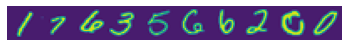

In [165]:
# Cargamos los datos que contienen las imagenes a tratar
data = loadmat ('ex3data1.mat')
y = data ['y']
X = data ['X']

# Para comprobar que hemos cargado los datos correctamente, cogemos una muestra de ellos (10) y los visualizamos
sample = np.random.choice(X.shape[0], 10)
plt.imshow(X[sample, :].reshape(-1, 20).T)
plt.axis('off')

In [166]:
# Funcion sigmoide, coste y gradiente que usaremos para el entrenamiento de los clasificadores de regresion logistica
# (son las mismas que las de la practica anterior, con regularizacion)

def sigmoide(z):
    return 1 / (1 + np.exp(-z))

def costeRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    return (np.matmul(np.log(sigmoide(np.matmul(X, theta))).T, Y)\
    + np.matmul(np.log(1 - sigmoide(np.matmul(X, theta)) + 1e-6).T, (1-Y)))/-m\
    + lamda* np.sum(theta**2)/(2*m)

def gradienteRegu(theta, X, Y, lamda):
    m = np.shape(X)[0]
    aux = lamda/m * theta
    aux[0] = 0
    return np.matmul(X.T, sigmoide(np.matmul(X,theta)) - Y)/m + aux

In [167]:
# Funcion que nos entrenara los 10 clasificadores, uno para reconocer cada digito

def oneVsAll(X, y, n_labels, reg):
    """oneVsAll entrena varios clasificadores por regresión logística con término
    de regularización 'reg' y devuelve el resultado en una matriz, donde
    la fila i-ésima corresponde al clasificador de la etiqueta i-ésima
    """
    
    theta = np.zeros(X.shape[1])
    theta_matrix = []
        
    for i in range(1, n_labels + 1) :
        y_cero = np.ravel((y == i) * 1)
        result = opt.fmin_tnc(func = costeRegu, x0 = theta, fprime = gradienteRegu, args=(X, y_cero, reg))
        theta_opt = result[0]
        theta_matrix.append(theta_opt)  
        
    theta_matrix = np.array(theta_matrix)
    
    return theta_matrix

In [168]:
# Añadimos una columna de 1's a la X, para poder realizar los calculos vectorialmente
m = X.shape[0]
X_conUnos = np.hstack([np.ones([m,1]), X])

# Obtenemos la matriz de pesos, donde cada fila corresponde a los pesos de un clasificador
theta_matrix = oneVsAll(X_conUnos, y, 10, 0.1)

In [169]:
#Obtenemos la probabilidad de cada uno de los clasificadores, para todos los ejemplos de entrenamiento
probability = sigmoide(np.matmul(X_conUnos, theta_matrix.T))
#Nos quedamos con el indice que contiene la mayor probabilidad 
#(Ojo: sumamos 1 porque el 0 esta codificado como 10 y asi hacemos corresponder los indices con las etiquetas)
index = np.argmax(probability, axis=1) + 1

#Imprimimos por pantalla que porcentaje de ejemplos de entrenamiento hemos clasificado correctamente
print(np.sum(index == np.ravel(y)) / len(y) * 100)

96.48


Comprobamos que, tal y como advierte el enunciado, para un valor del término de regularización de 0.1 el resultado está en torno al 95%.

### Parte 2: Redes Neuronales
El objetivo de esta segunda parte de la práctica es usar los pesos proporcionados para una red neuronal ya entrenada sobre los ejemplos. Con ello, podremos evaluar su precisión sobre el conjunto de entrenamiento. Por lo tanto, deberemos conseguir realizar el forward-propagation corréctamente. 

Para ello, cargamos los pesos del fichero *ex3weights.mat* e implementamos la propagación hacia adelante.

In [170]:
# Cargamos los pesos de la red neuronal
weights = loadmat('ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
# Obtenemos dos matrices de pesos, una para cada capa (sin tener en cuenta la capa de entrada)
# Theta1 es de dimension 25 x 401
# Theta2 es de dimension 10 x 26

In [171]:
# Funcion que nos computara el forward-propagation. 
def forwardPropagation(X, layers):
    #La variable 'a' corresponde a la entrada de cada capa, que al principio seran los datos de entrada X.
    #Ojo: trasponemos para tratar las dimensiones correctamente
    a = X.T
    
    for i in range(len(layers)):
        #Añadimos unos a la entrada de cada capa (los terminos independientes)
        a = np.vstack([np.ones([a.shape[1]]), a])
        
        #Cogemos los pesos correspondientes a la capa que toca
        thetas = layers[i]
        
        #Hacemos la multiplicacion
        z = np.matmul(thetas, a)
        
        #Y por ultimo la funcion de activacion
        a = sigmoide(z)
    
    #Al salir del bucle, tendremos la salida de la red neuronal
    #Trasponemos para devolver la misma forma que los datos de entrada
    return a.T

In [172]:
#Nuevamente, obtenemos la probabilidad para todos los ejemplos de entrenamiento, de que pertenezca a cada clase
probability = (forwardPropagation(X, [theta1, theta2]))
#Y volvemos a quedarnos con el indice que contiene la mayor probabilidad, ajustando correctamente los indices
index = np.argmax(probability, axis=1) + 1

#Por ultimo, imprimimos por pantalla el porcentaje de ejemplos de entrenamiento que hemos clasificado correctamente
print(np.sum(index == np.ravel(y)) / len(y) * 100)

97.52


Como observamos, tal y como nos dice el enunciado de la práctica, obtenemos una precisión de la red neuronal del 97.52%.